This notebook walks through the process of retrieving and cleaning TESS lightcurves for subsequent planet phase curve analysis.

# Imports

You will need to have the following packages installed:
- numpy: https://numpy.org/install/
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- pandas: https://pandas.pydata.org/docs/getting_started/install.html
- astropy: https://docs.astropy.org/en/stable/install.html
- lightkurve: https://docs.lightkurve.org/about/install.html
- astroquery: https://astroquery.readthedocs.io/en/latest/#installation

In [1]:
# General data manipulation and plotting packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u

# Exoplanet data packages
import lightkurve as lk
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

# Standard Python libraries (should not require installation)
import os # Operating system interfaces
from urllib.request import urlretrieve # Query with links
import re # Regular expressions

# The following are my preferred matplotlib settings; I use a custom font that I have saved locally on my system.
# You can adjust the lines below to suit your preferences, or just comment them out entirely.
from matplotlib import font_manager
font_dir = ['/home/paiasnodkar.1/fonts'] # This will not work for you since it is a local directory on my system
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

fontweight = 300
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Mulish']
plt.rcParams["font.weight"] = fontweight
plt.rcParams['axes.labelweight'] = 1.3*fontweight
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.titlesize'] = 22

# Retrieve lightcurve

For instructive purposes, we will explore ***KELT-9 b***, the hottest known planet and an ideal target for phase curve analysis due to the large temperature contrast between its day and night sides. The first step is to retrieve the known relevant planet parameters from the NASA Exoplanet Archive (NEA). We can do this within Python using the *astroquery* package.

For our purposes, we need the planet's ***transit ephemeris*** (plural: ephemerides), which are the temporal parameters that describe the planet's position. We will need the planet's orbital ***period***, ***mid-transit time***, and ***transit duration***. It is important to use consistent timing systems when applying the literature value of the mid-transit time to your data:
- BJD = ***Barycentric Julian Date***, the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System center of mass. This is the timing system of mid-transit time reported on NEA.
- BTJD = ***Barycentric TESS Julian Date***, the timestamp measured in BJD, but offset by 2457000.0, i.e. BTJD = BJD - 2457000.0. This is the timing system used for TESS data.

In [2]:
### Identify the planet and query the database ###
planet_name = 'KELT-9 b'
NEA_result = NasaExoplanetArchive.query_object(planet_name)
TIC_id = NEA_result['tic_id'][0] # extracts the TESS Input Catalog ID number associated with the planet

### Extract ephemeris information ###
# NEA reports numerous ephemeris solutions for this planet, let's just the first (zeroth since Python does 
# zero-based indexing) set of parameters.
ephemeris_ind = 0 
# Extract orbital period (P), mid-transit time (t_0), and transit duration (t_dur)
P, t_0, t_dur = NEA_result['pl_orbper'][ephemeris_ind], NEA_result['pl_tranmid'][ephemeris_ind], \
NEA_result['pl_trandur'][ephemeris_ind].value*u.hour
t_0 = t_0 - 2457000.0*u.day # Converting from BJD to BTJD

With the TIC ID, we can now use the *lightkurve* package to retrieve TESS photometry of this target.

In [3]:
# Use TIC ID to retrieve TESS SPOC (Science Processing Operations Center) 120 s cadence data
TESS_result = lk.search_lightcurve(TIC_id, mission='TESS', author='SPOC', exptime=120)
TESS_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,SPOC,120,16740101,0.0
1,TESS Sector 15,2019,SPOC,120,16740101,0.0
2,TESS Sector 41,2021,SPOC,120,16740101,0.0
3,TESS Sector 55,2022,SPOC,120,16740101,0.0
4,TESS Sector 75,2024,SPOC,120,16740101,0.0


As you can see, there are numerous (5) results for this planet. This is because of TESS's "stare and step" observing strategy:
<div>
<img src="notebook_images/TESS_SectorTiles.JPG" width="500"/>
</div>
TESS observes different slices (24° x 96° in angular size), referred to as sectors, to create a tiled map of the sky. Each sector is observed for two orbits of the satellite around the Earth, or about 27 days on average. You can learn more about TESS data collection <a href="https://tess.mit.edu/science/observations/">here</a>.


# One sector

Let's inspect the first available sector of data for this planet.

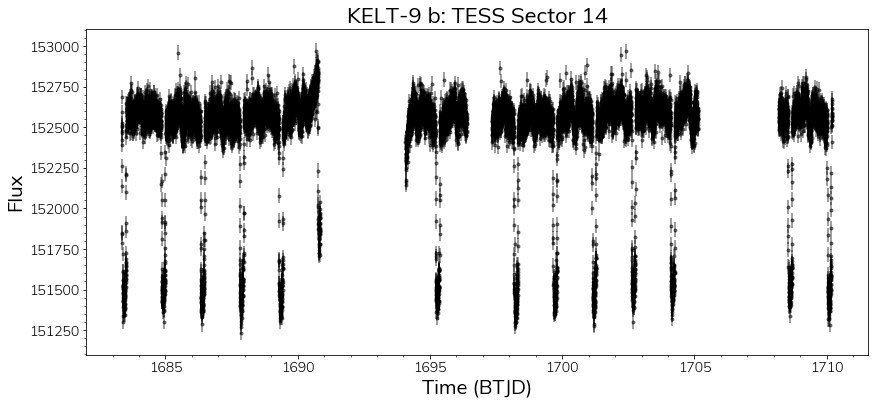

In [4]:
sector_ind = 0 # select the first (zeroth) sector returned by the lightkurve search result
sector = TESS_result.mission[sector_ind]

# Get lightcurve
lc = TESS_result[sector_ind].download() # by default ignores cadences with severe quality issues


# Plot lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector)
plt.show()

There are numerous interesting features in this lightcurve, some of which are astrophysical and some of which are systematics that need to be removed. In this notebook we will ***remove the systematics as well as the transits/secondary eclipses*** since these signals dominate and obscure the planet's relatively faint atmosphere brightness modulation (the phase curve signal of interest). Other astrophysical signals from the star will require more sophisticated modelling and are accounted for in the modelling notebook.

Lightcurves are extracted from TESS images of the sky with a technique called ***aperture photometry***. With this technique, an aperture is defined, e.g. a circle of pixels containing the target star of interest. The flux from each pixel in that aperture is summed together to produce a single flux value for the star. This is done for many images taken at a regular cadence (we are using the ***2-minute cadence data***) over time to construct a lightcurve, i.e. flux measured over time.

TESS photometry comes in two varieties:
- **Simple Aperture Photometry (SAP)**: The act of summing all pixel values in a pre-defined aperture as a function of time.
- **Pre-search Data Conditioning SAP flux (PDCSAP) flux** : SAP flux from which long term trends have been removed using so-called Co-trending Basis Vectors (CBVs). PDCSAP flux is usually cleaner data than the SAP flux and will have fewer systematic trends.

We are using TESS PDCSAP lightcurves, which we will refer to as PDC for short. In principle, systematics from noise sources such as scattered light and instrumental effects should be detrended (corrected) in these data. Any egregiously bad data points should have been removed or set to NaN (not a number). To be sure of that, let's remove any data points that are associated with a bad data quality flag. To do that, we will construct a mask, which is an array of booleans (True or False) that are True if the quality flag is bad.

Bad data quality flags present in Sector TESS Sector 14
Flag: 0 , Reason: 


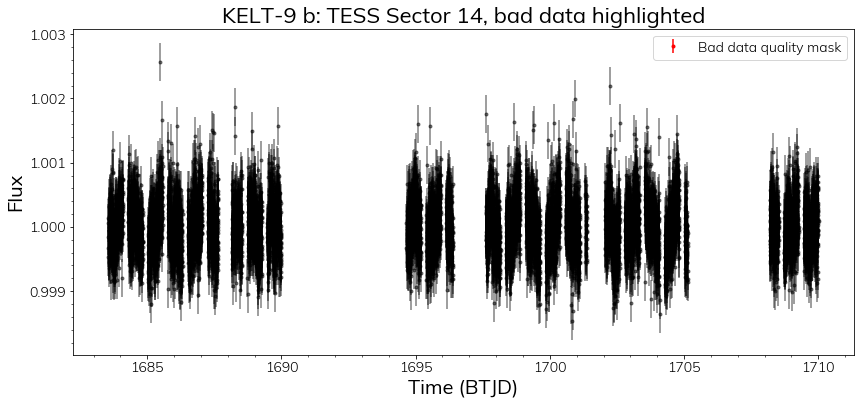

In [13]:
# Bad data quality flags present in our data
print('Bad data quality flags present in Sector '+str(sector))
for flag in np.unique(lc.quality):
    print('Flag:', flag, ', Reason:', ' '.join(lk.TessQualityFlags.decode(flag)))
    
# Mask of bad data quality points    
mask_bad = lc.quality != 0 # bad data have non-zero quality flags

# Plot lightcurve with bad data highlighted in red
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.errorbar(lc.time.value[mask_bad], lc.flux.value[mask_bad], lc.flux_err.value[mask_bad], fmt='.', color='r', 
             label='Bad data quality mask')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', bad data highlighted')
plt.legend(fontsize=14)
plt.show()

Let's also make a mask to remove transits and secondary eclipses.

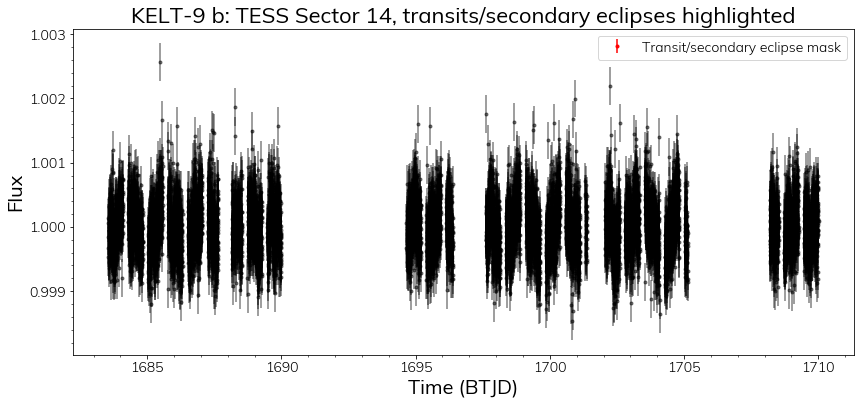

In [14]:
# Use P/2 for the period to include both transits and secondary eclipses (valid for ~circular orbits)
# Including a bit beyond nominal transit duration for good measure in case the ephemeris is not precise
mask_transit = lc.create_transit_mask(period=P/2., transit_time=t_0, duration=1.2*t_dur) 

# Plot lightcurve with transits/secondary eclipses highlighted in red
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.errorbar(lc.time.value[mask_transit], lc.flux.value[mask_transit], lc.flux_err.value[mask_transit], 
             fmt='.', color='r', label='Transit/secondary eclipse mask')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', transits/secondary eclipses highlighted')
plt.legend(fontsize=14)
plt.show()

Flux ramps the TESS spacecraft's "momentum dumps" orbit are systematics that are often seen but not removed in the PDC pipeline. As stated in <a href="https://ui.adsabs.harvard.edu/abs/2020AJ....160...88W/abstract">Wong et al. 2020</a>, "these events can cause discontinuities in flux and, in some cases, short-term photometric variability before and/or after." Let's mask out observations taken around the time of a momentum dump.

/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


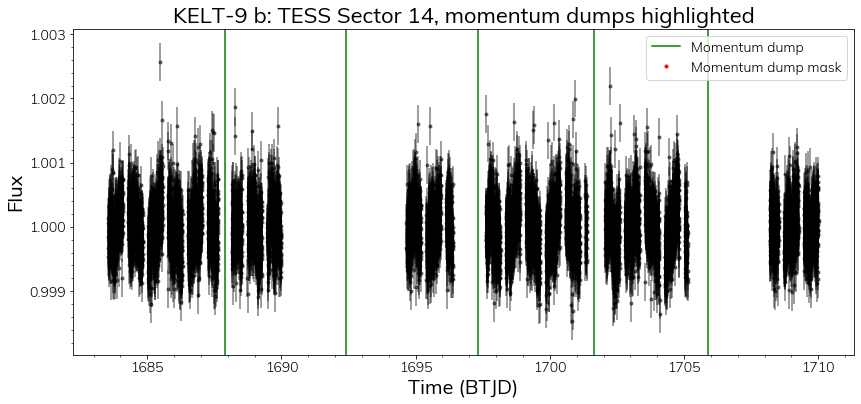

In [15]:
# Download the table of momentum dumps
url = 'https://tess.mit.edu/public/files/Table_of_momentum_dumps.csv'
filename = 'Table_of_momentum_dumps.csv'
fullfilename = os.path.join(os.getcwd(), filename) # Path at which to save the file
urlretrieve(url, fullfilename); # Retrieves and saves the file locally

# Read in momentum dumps
momentum_dumps = np.genfromtxt(filename, delimiter=",", comments='#') # read table
momentum_dumps_times = momentum_dumps[:, 1] # 4th column gives the cadences of the dumps
momentum_dumps_times = momentum_dumps_times[(momentum_dumps_times>min(lc.time.value)-0.25) & 
                                            (momentum_dumps_times<max(lc.time.value)+0.25)] # Select only dumps in sector
# Clean up momentum dump data
momentum_dumps_times_copy = np.copy(momentum_dumps_times)
momentum_dumps_times = np.array([])
for time in momentum_dumps_times_copy:
    similar = np.where(abs(momentum_dumps_times_copy - time) <= 0.25)
    momentum_dumps_times = np.hstack([momentum_dumps_times, np.mean(momentum_dumps_times_copy[similar])])
    momentum_dumps_times = np.delete(momentum_dumps_times, similar)
momentum_dumps_times = np.unique(momentum_dumps_times[~np.isnan(momentum_dumps_times)])

# Construct mask identifying data points taken within 0.25 days of a momentum dump
mask_dumps = np.array([False]*len(lc.time.value))
for dump_time in momentum_dumps_times:
    mask_dumps += abs(lc.time.value-dump_time) <= 0.25

# Plot lightcurve with observations taken near momentum dumps highlighted in red
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.errorbar(lc.time.value[mask_dumps], lc.flux.value[mask_dumps], fmt='.', color='r', label='Momentum dump mask')
for i, dump_time in enumerate(momentum_dumps_times):
    if i == 0:
        plt.axvline(dump_time, color='g', label='Momentum dump')
    else:
        plt.axvline(dump_time, color='g')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', momentum dumps highlighted')
plt.legend(fontsize=14)
plt.show()

Finally, let's remove points that show flux ramps (sudden rises or falls that are unlikely to be astrophysical) that have not been accounted for. This requires our own personal judgement. One such example can be seen between days 1690 and 1691.5 and another between days 1694 and 1694.5.

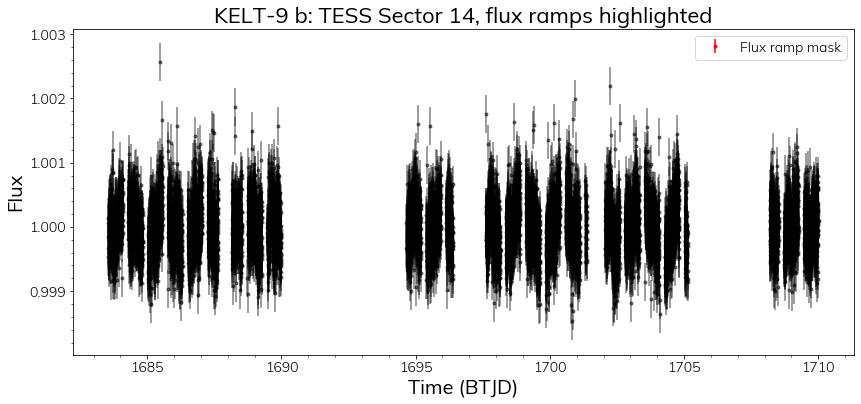

In [16]:
# Create an array with pairs of times that correspond to the start and end times of a flux ramp
flux_ramps = np.array([[1690, 1691.5],
                       [1694, 1694.5]])

# Go through each pair of flux ramp start/end times and mask out the observations that fall in between 
mask_ramps = np.array([False]*len(lc.time.value))
for flux_ramp in flux_ramps:
    ind_ramp = np.argwhere((lc.time.value > flux_ramp[0]) & (lc.time.value < flux_ramp[1]))
    mask_ramps[ind_ramp] = True
    
# Plot lightcurve with flux ramps highlighted in red
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.errorbar(lc.time.value[mask_ramps], lc.flux.value[mask_ramps], lc.flux_err.value[mask_ramps], 
             fmt='.', color='r', label='Flux ramp mask')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', flux ramps highlighted')
plt.legend(fontsize=14)
plt.show()

Now that we've identified all the data points we want to throw out, let's combine all the masks and remove them from our Lightkurve object.

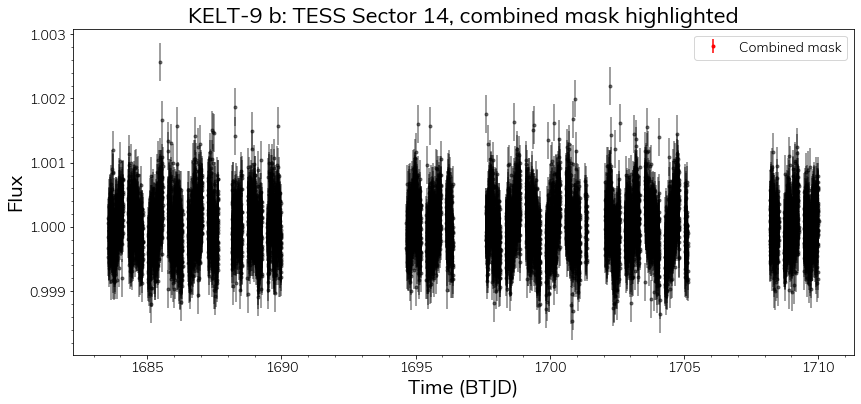

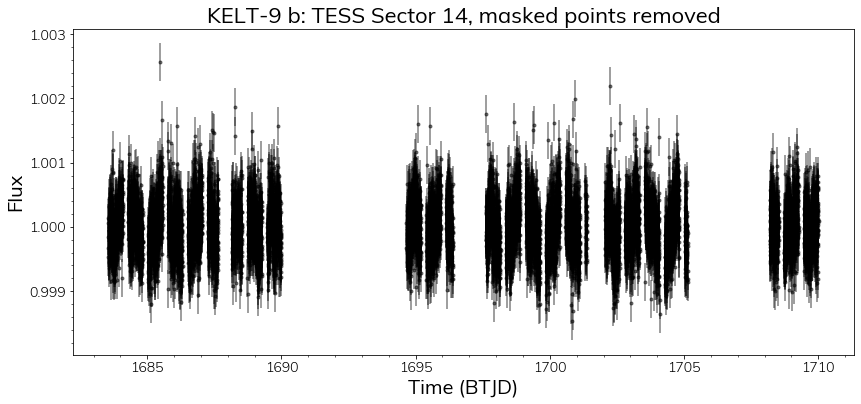

In [17]:
mask = mask_bad + mask_transit + mask_dumps + mask_ramps

# Plot data with the combined mask highlighted in red
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.errorbar(lc.time.value[mask], lc.flux.value[mask], lc.flux_err.value[mask], 
             fmt='.', color='r', label='Combined mask')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', combined mask highlighted')
plt.legend(fontsize=14)
plt.show()

# Remove the masked points
lc = lc[~mask]

# Plot data with masked points removed
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', masked points removed')
plt.show()

The last step we need to take before we can fit these data to our phase curve models is to detrend the lightcurve. This involves finding the best-fit low-order (degree <= 2) polynomial fit to each segment of data separated by momentum dumps.  This will wash out any long term wiggles caused by instrumental effects without wiping out variations on the shorter timescales on which expect to see the planet's atmospheric brightness to modulate (same periodicity as the planet's orbital motion).

Segment:  0 , optimized normalization polynomial degree:  1 , AIC:  0.0003644683834633393
Segment:  1 , optimized normalization polynomial degree:  1 , AIC:  0.00015203213530245468
Segment:  2 , optimized normalization polynomial degree:  0 , AIC:  0.00014034661963542575
Segment:  3 , optimized normalization polynomial degree:  0 , AIC:  0.0003575383022242595
Segment:  4 , optimized normalization polynomial degree:  1 , AIC:  0.0003038972171635542


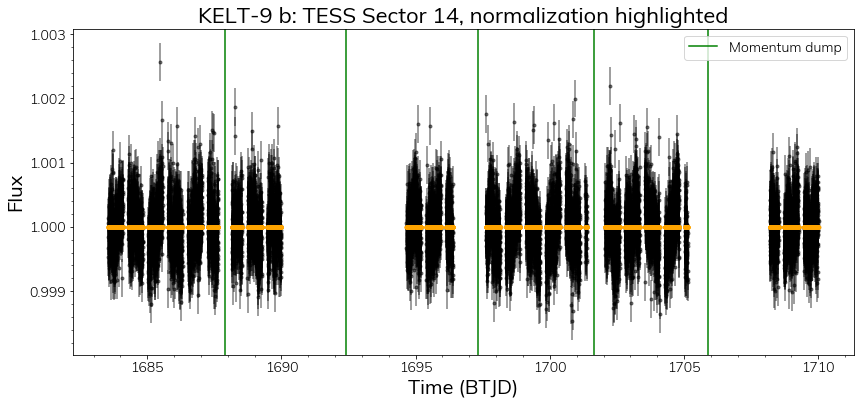

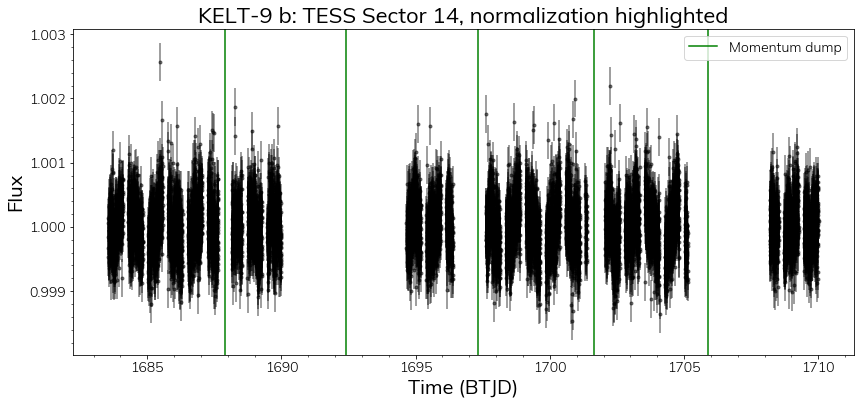

In [18]:
normalization = np.array([])
begin = min(lc.time.value)

for i, dump in enumerate(momentum_dumps_times):
    SSE_best, normalization_best, deg_best = np.inf, None, None
    
    # Select data within a given momentum dump segment
    segment = (lc.time.value >= begin) * (lc.time.value < dump)
    if np.sum(segment) == 0:
        continue
    time_segment, flux_segment = lc.time.value[segment], lc.flux.value[segment]
    
    # Test best polynomial fit
    for deg in range(3):
        p = np.polyfit(time_segment, flux_segment, deg)
        f = np.poly1d(p)
        normalization_deg = f(time_segment)
        SSE = np.sum((flux_segment - normalization_deg)**2)
#         AIC = 2*(deg + 1) - 2*np.log(SSE)
        if SSE < SSE_best:
            SSE_best = SSE
            normalization_best = normalization_deg
            deg_best = deg
    normalization = np.hstack([normalization, normalization_best])
    print('Segment: ', i, ', optimized normalization polynomial degree: ', deg_best, ', SSE: ', SSE_best)
    begin = np.copy(dump)
    if i == len(momentum_dumps_times)-1:
        SSE_best, normalization_best, deg_best = np.inf, None, None
        
        # Select data within a given momentum dump segment
        segment = (lc.time.value > begin)
        if np.sum(segment) == 0:
            break
        time_segment, flux_segment = lc.time.value[segment], lc.flux.value[segment]

        # Test best polynomial fit
        for deg in range(3):
            p = np.polyfit(time_segment, flux_segment, deg)
            f = np.poly1d(p)
            normalization_deg = f(time_segment)
            SSE = np.sum((flux_segment - normalization_deg)**2)
#             AIC = 2*(deg + 1) - 2*np.log(SSE)
            if SSE < SSE_best:
                SSE_best = SSE
                normalization_best = normalization_deg
                deg_best = deg
        normalization = np.hstack([normalization, normalization_best])
        print('Segment: ', i+1, ', optimized normalization polynomial degree: ', deg_best, ', SSE: ', SSE_best)

# Plot lightcurve with observations with normalization continuum
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=0)
plt.plot(lc.time.value, normalization, '.', color='orange', label='Polynomial trend')
for i, dump_time in enumerate(momentum_dumps_times):
    if i == 0:
        plt.axvline(dump_time, color='g', label='Momentum dump')
    else:
        plt.axvline(dump_time, color='g')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', normalization highlighted')
plt.legend(fontsize=14)
plt.show()

# Normalize
lc = lc/normalization

# Plot normalized lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=0)
for i, dump_time in enumerate(momentum_dumps_times):
    if i == 0:
        plt.axvline(dump_time, color='g', label='Momentum dump')
    else:
        plt.axvline(dump_time, color='g')
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.title(planet_name+': '+sector+', normalization highlighted')
plt.legend(fontsize=14)
plt.show()

For ease of visualization, let's phase-fold the lightcurve over the orbital period. We should see one cycle of the planet's brightness modulation as the dominant variation in the phase-folded lightcurve. Phase-folding requires providing the period over which to fold over (orbital period *P*) and a reference epoch time corresponding phase 0. We can set this epoch time to the mid-transit time (*t_0*) such that transits happen at phase = 0 = 1 while secondary eclipses occur at phase = 0.5. However, we will see gaps at those phases because we masked out transits and secondary eclipses.

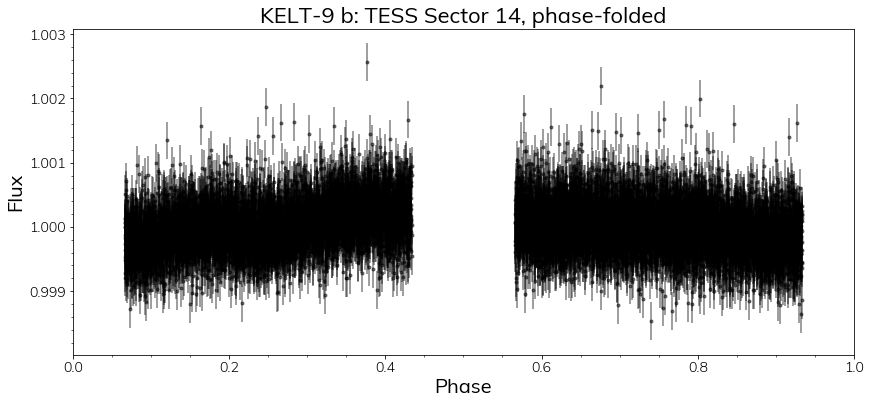

In [19]:
# Phase-fold lightcurve
lc_fold = lc.fold(P, epoch_time=t_0, normalize_phase=True) # need normalize_phase=True to define phase from -0.5 to 0.5
lc_fold.phase[lc_fold.phase<0] = lc_fold.phase[lc_fold.phase<0] + 1. # wrap phases to go from 0 to 1

# Plot phase-folded lightcurve
plt.figure(figsize=(14,6))
plt.errorbar(lc_fold.phase.value, lc_fold.flux.value, lc_fold.flux_err.value, fmt='.', color='k', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.xlim(0, 1)
plt.title(planet_name+': '+sector+', phase-folded')
plt.show()

As expected for the phase curve of a tidally-locked transiting planet, we see one cycle of modulation over the planet's orbital period, with the brightness peaking near secondary eclipse (when the planet's hot dayside is facing us, the observer) and dimmest near transit (when the planet's hot nightside is facing us).

# All sectors

Let's combine what we've done above for one sector in a loop to do it for all sectors and save the cleaned data.

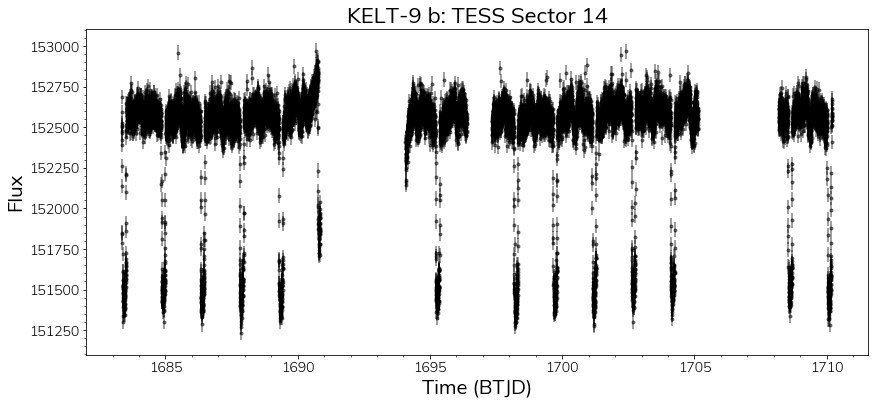

/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


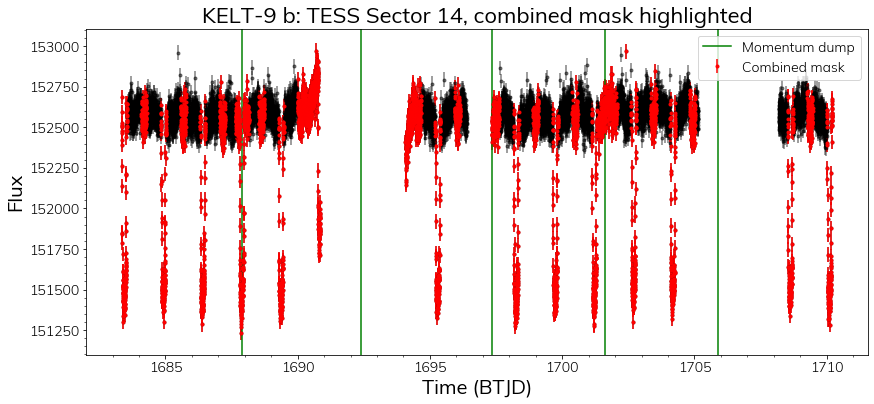

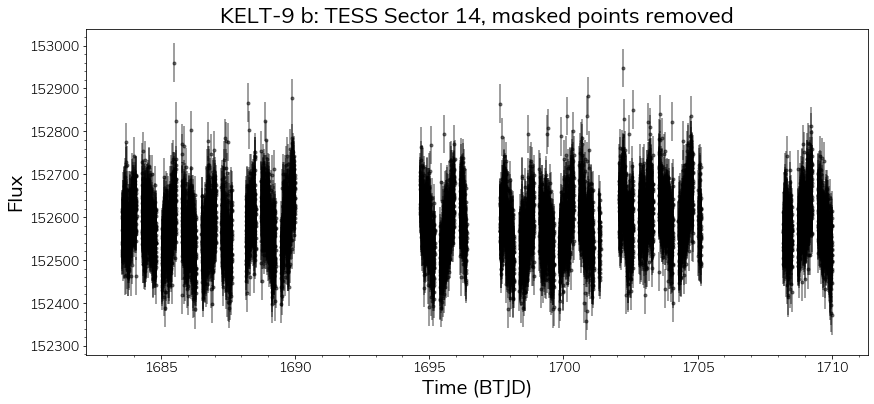

Segment:  0 , optimized normalization polynomial degree:  2 , SSE:  8487023.32871532
Segment:  1 , optimized normalization polynomial degree:  2 , SSE:  4391602.620949069
Segment:  2 , optimized normalization polynomial degree:  2 , SSE:  4107925.3749985094
Segment:  3 , optimized normalization polynomial degree:  2 , SSE:  8767611.126601622
Segment:  4 , optimized normalization polynomial degree:  2 , SSE:  7086121.982080917
Segment:  5 , optimized normalization polynomial degree:  2 , SSE:  3518643.518732178


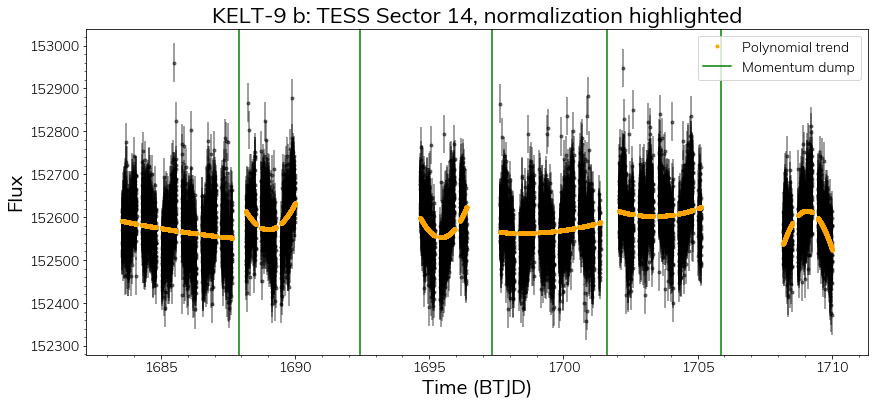

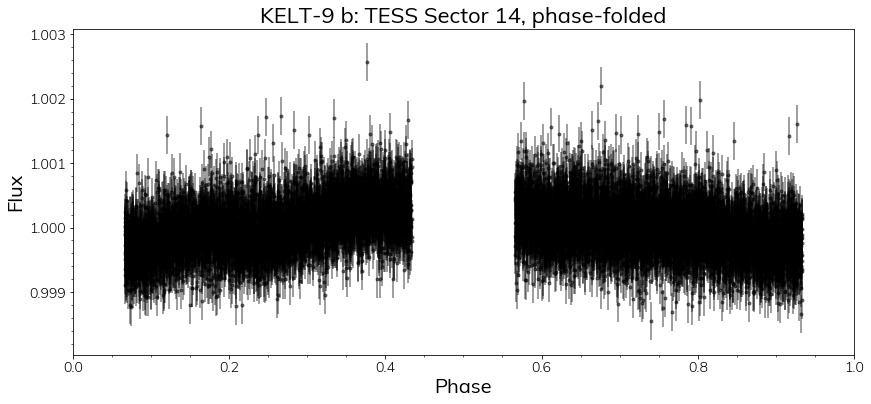

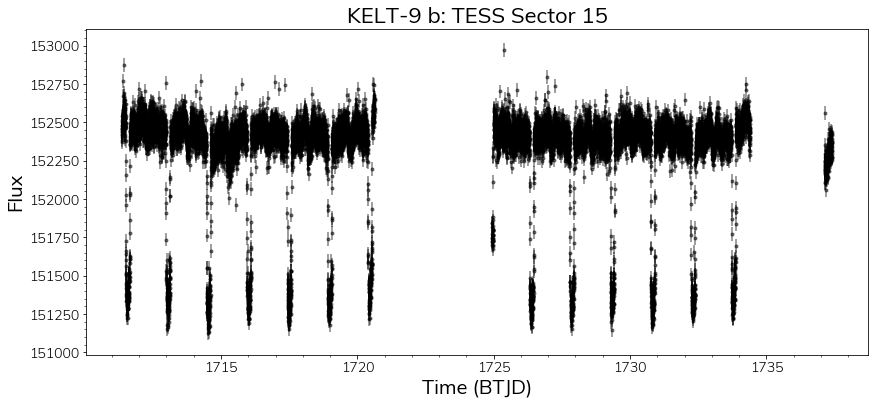

/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


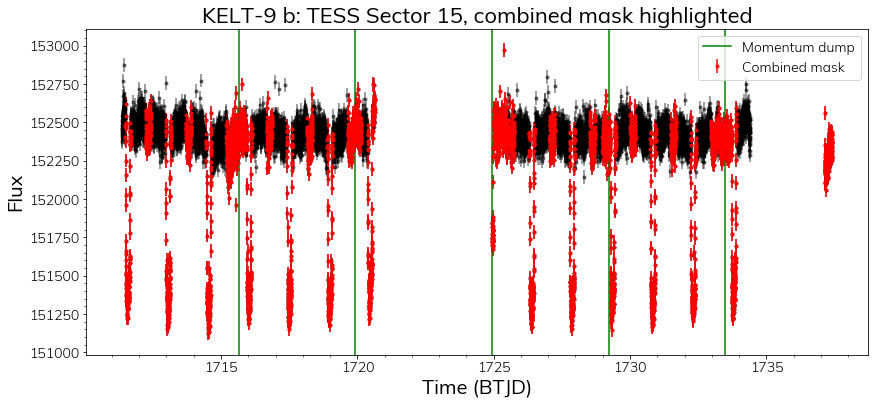

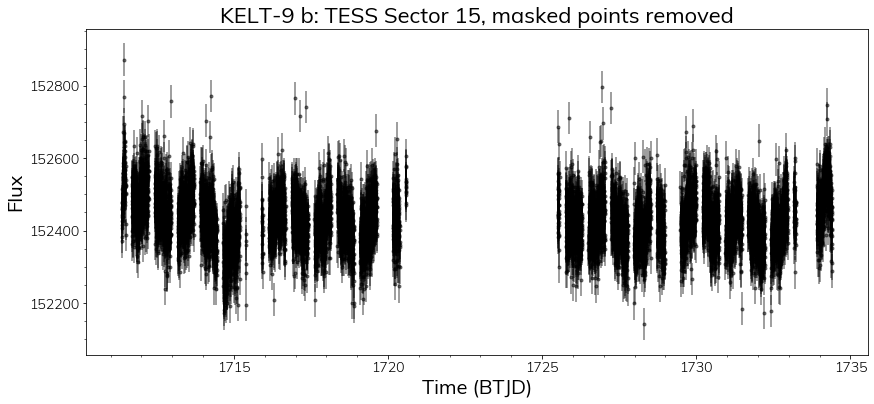

Segment:  0 , optimized normalization polynomial degree:  2 , SSE:  10323169.48558984
Segment:  1 , optimized normalization polynomial degree:  2 , SSE:  8065005.075439131
Segment:  2 , optimized normalization polynomial degree:  2 , SSE:  758014.2100251592
Segment:  3 , optimized normalization polynomial degree:  2 , SSE:  7757737.976965146
Segment:  4 , optimized normalization polynomial degree:  2 , SSE:  8145821.1471650675
Segment:  5 , optimized normalization polynomial degree:  2 , SSE:  1346602.0831890963


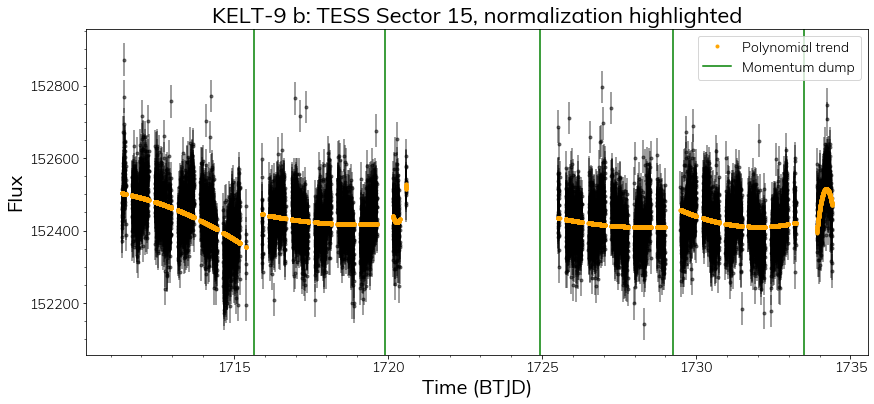

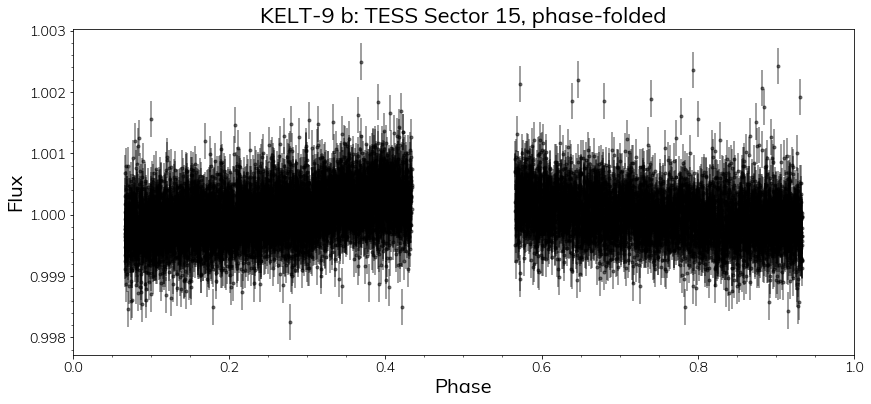

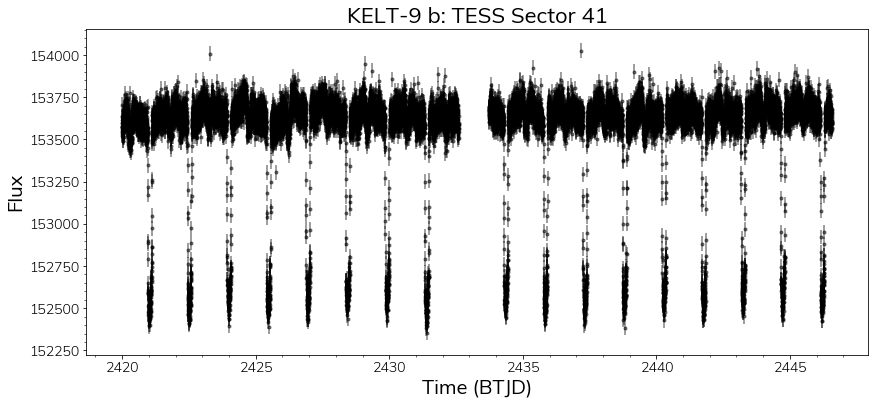

/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


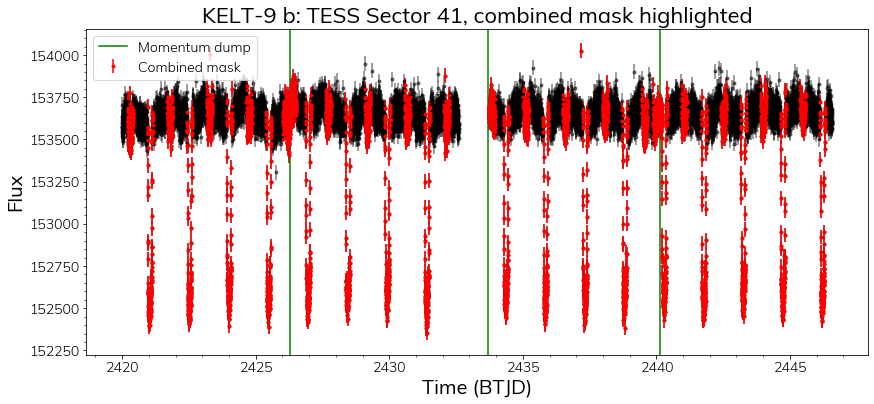

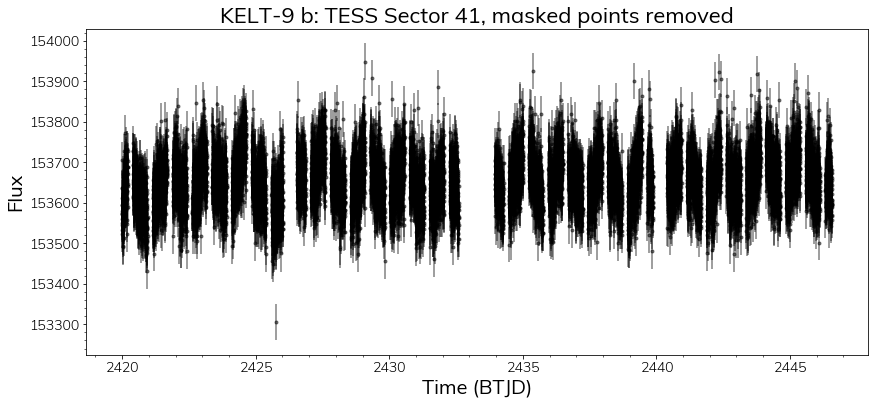

Segment:  0 , optimized normalization polynomial degree:  2 , SSE:  11800065.930383427
Segment:  1 , optimized normalization polynomial degree:  2 , SSE:  11197961.768556496
Segment:  2 , optimized normalization polynomial degree:  2 , SSE:  10820707.783099499
Segment:  3 , optimized normalization polynomial degree:  2 , SSE:  11630142.023436952


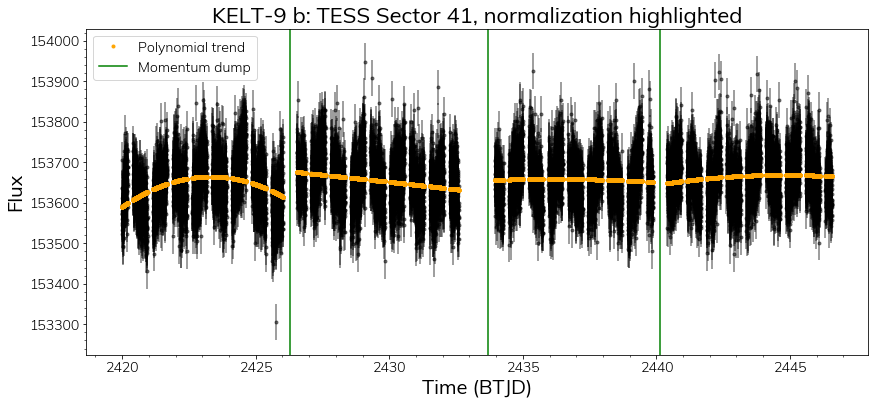

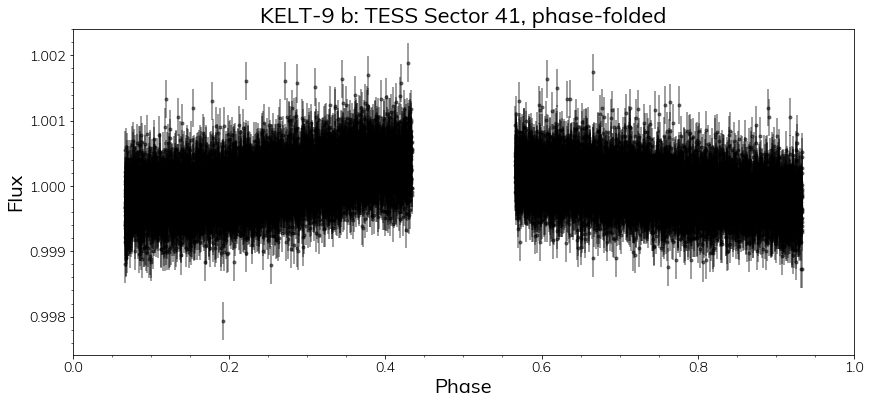

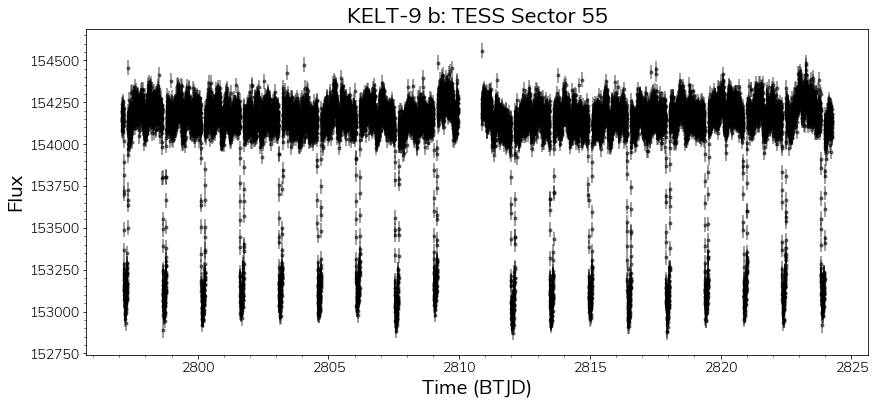

/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


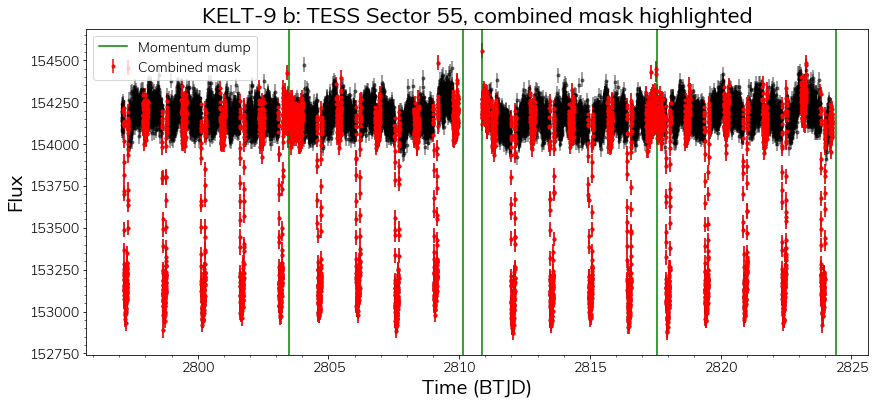

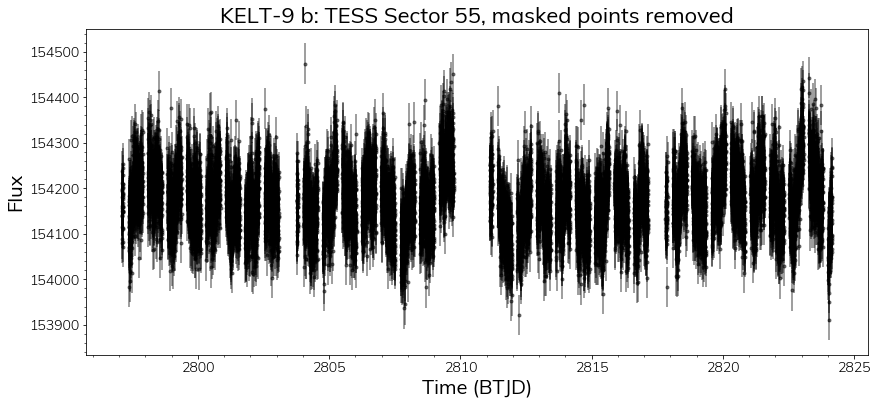

Segment:  0 , optimized normalization polynomial degree:  2 , SSE:  10999853.156737387
Segment:  1 , optimized normalization polynomial degree:  2 , SSE:  14316781.57147983
Segment:  3 , optimized normalization polynomial degree:  2 , SSE:  12250547.010620689
Segment:  4 , optimized normalization polynomial degree:  2 , SSE:  14836038.865032379


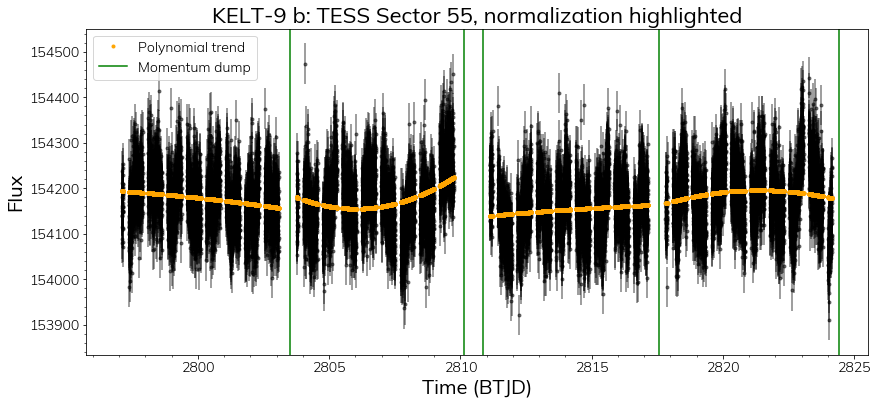

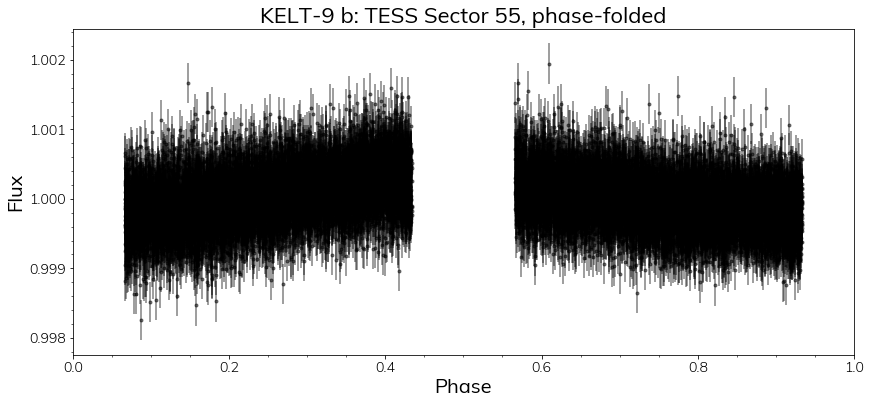

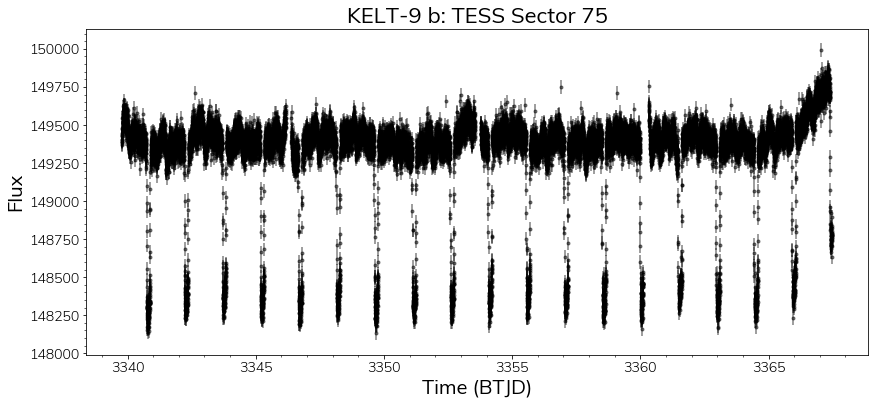

/home/paiasnodkar.1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


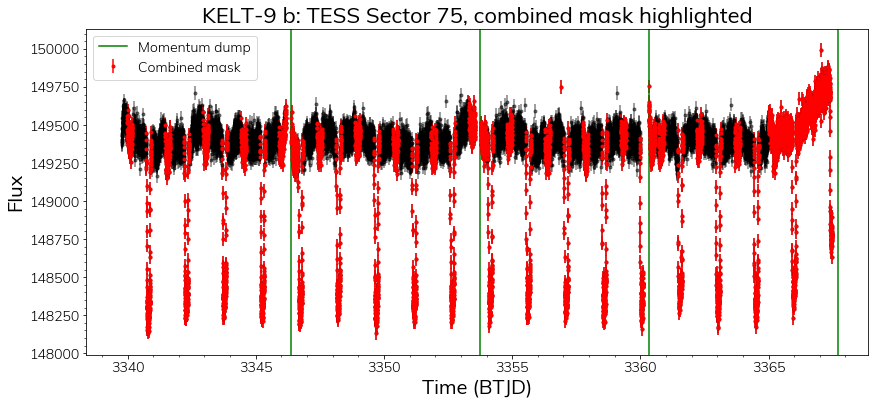

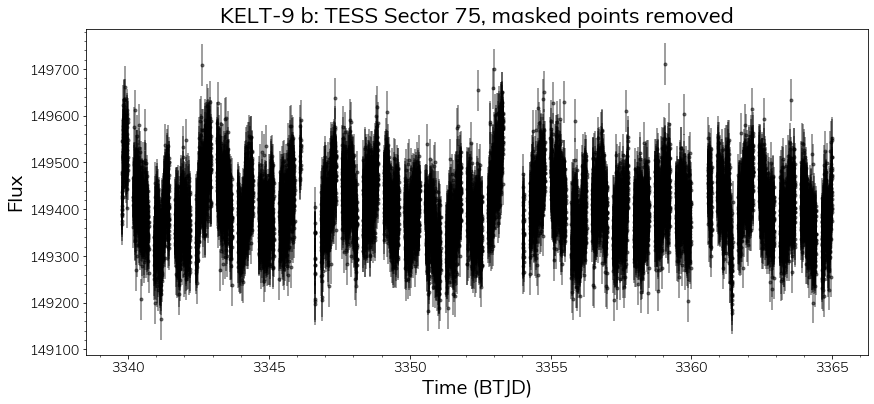

Segment:  0 , optimized normalization polynomial degree:  2 , SSE:  16772972.948578153
Segment:  1 , optimized normalization polynomial degree:  2 , SSE:  16054962.098552927
Segment:  2 , optimized normalization polynomial degree:  2 , SSE:  11941897.782560952
Segment:  3 , optimized normalization polynomial degree:  2 , SSE:  8537443.543130424


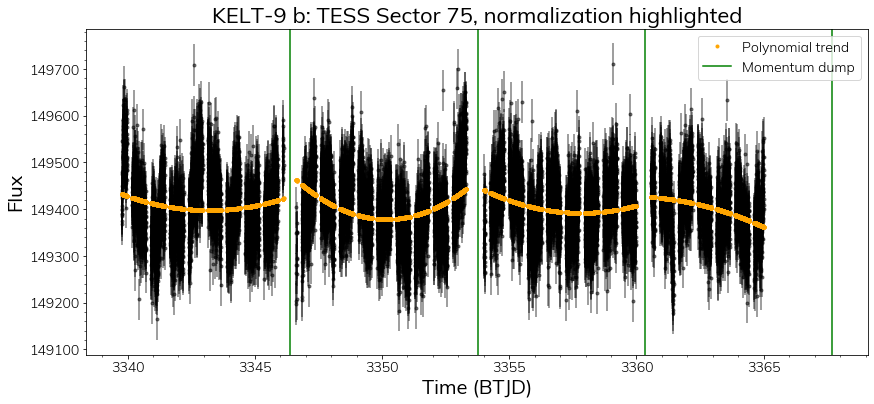

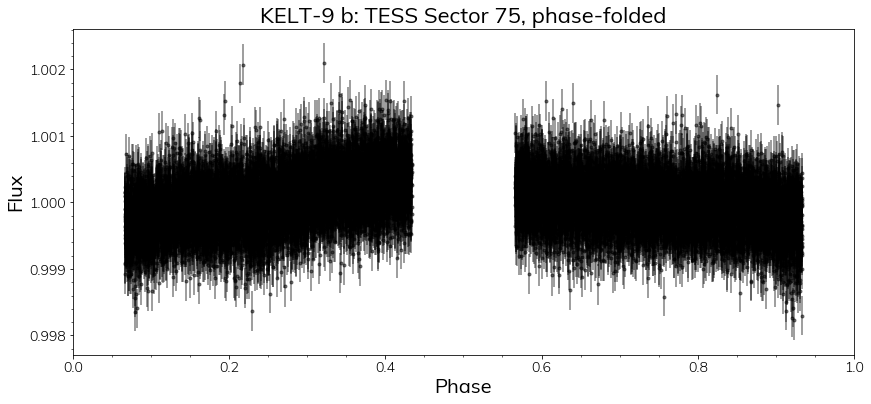

In [24]:
# Download the table of momentum dumps
url = 'https://tess.mit.edu/public/files/Table_of_momentum_dumps.csv'
filename = 'Table_of_momentum_dumps.csv'
fullfilename = os.path.join(os.getcwd(), filename) # Path at which to save the file
urlretrieve(url, fullfilename); # Retrieves and saves the file locally

# Read in momentum dumps
momentum_dumps = np.genfromtxt(filename, delimiter=",", comments='#') # read table

# Array of flux ramps
flux_ramps = np.array([[1690, 1691.5],
                       [1694, 1694.5],
                       [1720.6, 1725.5],
                       [1735, 1738],
                       [3365, 3368]])

# Initialize a dictionary to save the data
df_dict = {
    'sector': np.array([]),
    'time': np.array([]),
    'flux': np.array([]),
    'flux_err': np.array([])
}

# Loop through all sectors
for sector_ind in range(len(TESS_result)):
    # Select the sector
    sector = TESS_result.mission[sector_ind]
    sector_num = int(re.findall(r'\d+', sector)[0])

    # Get lightcurve
    lc = TESS_result[sector_ind].download() # by default ignores cadences with severe quality issues
    
    # Plot the lightcurve for visual inspection, particularly to identify unexpected phase ramps
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name+': '+sector)
    plt.show()
    
    # Mask of bad data quality points    
    mask_bad = lc.quality != 0 # bad data have non-zero quality flags
    
    # Mask of transits and secondary eclipses
    mask_transit = lc.create_transit_mask(period=P/2., transit_time=t_0, duration=1.2*t_dur) 
    
    # Mask of momentum dumps    
    momentum_dumps_times = momentum_dumps[:, 1] # 4th column gives the cadences of the dumps
    momentum_dumps_times = momentum_dumps_times[(momentum_dumps_times>min(lc.time.value)-0.25) & 
                                                (momentum_dumps_times<max(lc.time.value)+0.25)] # Select only dumps in sector
    # Clean up momentum dump data
    momentum_dumps_times_copy = np.copy(momentum_dumps_times)
    momentum_dumps_times = np.array([])
    for time in momentum_dumps_times_copy:
        similar = np.where(abs(momentum_dumps_times_copy - time) <= 0.25)
        momentum_dumps_times = np.hstack([momentum_dumps_times, np.mean(momentum_dumps_times_copy[similar])])
        momentum_dumps_times = np.delete(momentum_dumps_times, similar)
    momentum_dumps_times = np.unique(momentum_dumps_times[~np.isnan(momentum_dumps_times)])
    
    mask_dumps = np.array([False]*len(lc.time.value))
    for dump_time in momentum_dumps_times:
        mask_dumps += abs(lc.time.value-dump_time) <= 0.25
        
    # Go through each pair of flux ramp start/end times and mask out the observations that fall in between 
    mask_ramps = np.array([False]*len(lc.time.value))
    for flux_ramp in flux_ramps:
        ind_ramp = np.argwhere((lc.time.value > flux_ramp[0]) & (lc.time.value < flux_ramp[1]))
        mask_ramps[ind_ramp] = True
        
    mask = mask_bad + mask_transit + mask_dumps + mask_ramps
        
    # Plot data with the combined mask highlighted in red
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.errorbar(lc.time.value[mask], lc.flux.value[mask], lc.flux_err.value[mask], 
                 fmt='.', color='r', label='Combined mask')
    for i, dump_time in enumerate(momentum_dumps_times):
        if i == 0:
            plt.axvline(dump_time, color='g', label='Momentum dump')
        else:
            plt.axvline(dump_time, color='g')
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name+': '+sector+', combined mask highlighted')
    plt.legend(fontsize=14)
    plt.show()

    # Remove the masked points
    lc = lc[~mask]

    # Plot data with masked points removed
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name+': '+sector+', masked points removed')
    plt.show()
    
    # Normalize/long-term detrending across momentum dumps
    normalization = np.array([])
    begin = min(lc.time.value)
    for i, dump in enumerate(momentum_dumps_times):
        SSE_best, normalization_best, deg_best = np.inf, None, None

        # Select data within a given momentum dump segment
        segment = (lc.time.value >= begin) * (lc.time.value < dump)
        if np.sum(segment) == 0:
            continue
        time_segment, flux_segment = lc.time.value[segment], lc.flux.value[segment]

        # Test best polynomial fit
        for deg in range(3):
            p = np.polyfit(time_segment, flux_segment, deg)
            f = np.poly1d(p)
            normalization_deg = f(time_segment)
            SSE = np.sum((flux_segment - normalization_deg)**2)
            if SSE < SSE_best:
                SSE_best = SSE
                normalization_best = normalization_deg
                deg_best = deg
        normalization = np.hstack([normalization, normalization_best])
        print('Segment: ', i, ', optimized normalization polynomial degree: ', deg_best, ', SSE: ', SSE_best)
        begin = np.copy(dump)
        if i == len(momentum_dumps_times)-1:
            SSE_best, normalization_best, deg_best = np.inf, None, None

            # Select data within a given momentum dump segment
            segment = (lc.time.value > begin)
            if np.sum(segment) == 0:
                break
            time_segment, flux_segment = lc.time.value[segment], lc.flux.value[segment]

            # Test best polynomial fit
            for deg in range(3):
                p = np.polyfit(time_segment, flux_segment, deg)
                f = np.poly1d(p)
                normalization_deg = f(time_segment)
                SSE = np.sum((flux_segment - normalization_deg)**2)
                if SSE < SSE_best:
                    SSE_best = SSE
                    normalization_best = normalization_deg
                    deg_best = deg
            normalization = np.hstack([normalization, normalization_best])
            print('Segment: ', i+1, ', optimized normalization polynomial degree: ', deg_best, ', SSE: ', SSE_best)
            
    # Plot lightcurve with observations with normalization continuum
    plt.figure(figsize=(14,6))
    plt.errorbar(lc.time.value, lc.flux.value, lc.flux_err.value, fmt='.', color='k', alpha=0.5, zorder=0)
    plt.plot(lc.time.value, normalization, '.', color='orange', label='Polynomial trend')
    for i, dump_time in enumerate(momentum_dumps_times):
        if i == 0:
            plt.axvline(dump_time, color='g', label='Momentum dump')
        else:
            plt.axvline(dump_time, color='g')
    plt.xlabel('Time (BTJD)')
    plt.ylabel('Flux')
    plt.title(planet_name+': '+sector+', normalization highlighted')
    plt.legend(fontsize=14)
    plt.show()
    
    lc = lc/normalization
    
    # Phase-fold
    lc_fold = lc.fold(P, epoch_time=t_0, normalize_phase=True) # need normalize_phase=True to define phase from -0.5 to 0.5
    lc_fold.phase[lc_fold.phase<0] = lc_fold.phase[lc_fold.phase<0] + 1. # wrap phases to go from 0 to 1

    # Plot phase-folded lightcurve
    plt.figure(figsize=(14,6))
    plt.errorbar(lc_fold.phase.value, lc_fold.flux.value, lc_fold.flux_err.value, fmt='.', color='k', alpha=0.5)
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    plt.xlim(0, 1)
    plt.title(planet_name+': '+sector+', phase-folded')
    plt.show()
    
    df_dict['sector'] = np.int64(np.hstack([df_dict['sector'], sector_num*np.ones_like(lc.time.value)]))
    df_dict['time'] = np.hstack([df_dict['time'], lc.time.value])
    df_dict['flux'] = np.hstack([df_dict['flux'], lc.flux.value])
    df_dict['flux_err'] = np.hstack([df_dict['flux_err'], lc.flux_err.value])
    
# Save data
data_dir = os.getcwd() + '/lightcurves/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
df = pd.DataFrame(df_dict)
df.to_csv('lightcurves/'+planet_name.replace(" ", "")+'.csv', index=False);    